# Connect to Google Drive

In [0]:
#Step 1 part 1: connect to drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# Train the model

In [0]:
import numpy as np
import pandas as pd
from random import sample
import pickle, cv2
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras import applications, optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import plot_model
import json

In [0]:
def train_validation_split(x, y):
    X_training, X_test, y_training, y_test = train_test_split(x, y, stratify=y, random_state=1337)
    X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, stratify=y_training, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
def one_hot(y_train, y_val, y_test, n_classes):
    y_train = np_utils.to_categorical(y_train, n_classes)
    y_val = np_utils.to_categorical(y_val, n_classes)
    y_test = np_utils.to_categorical(y_test, n_classes)

    return y_train, y_val, y_test

In [0]:
def build_fit_save_cnn(input_shape, n_classes, epochs, batch_size, X_train, X_val, y_train, y_val):
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dropout(0.25))
    add_model.add(Dense(n_classes, activation='softmax'))

    # combine base model and fully connected layers
    final_model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    # specify SDG optimizer parameters
    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

    # compile model
    final_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    history = final_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))

    score = final_model.evaluate(X_val, y_val, verbose=0)
    print('Val. score:', score[0])
    print('Val. accuracy:', score[1])
    
    plot_model(final_model, to_file='drive/ML-Kaggle/CNN-VGG19-Kaggle-Model.svg')
    show_history(history)
    save_model(final_model,history)

    return final_model

In [0]:
def test_predict_score(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    test_pred = model.predict(X_test)

    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    return test_pred, score

In [0]:
def save_model(model,history):
    
    open('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle.json', 'w').close()
    open('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle-weights.h5', 'w').close()
    
    model_json = model.to_json()
    with open('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle.json', 'w') as json_file:
        json_file.write(model_json)

    model.save_weights('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle-weights.h5')
    print('Model saved to disk!')
    
    with open('drive/ML-Kaggle/Data/CNN-VGG19-Kaggle-History.json', 'w') as f:
        json.dump(history.history, f)
    print('History saved to disk!')

In [0]:
def show_history(history):
    print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Train on 675 samples, validate on 225 samples
Epoch 1/10
675/675 [==============================] - 13s 20ms/step - loss: 1.0777 - acc: 0.4400 - val_loss: 0.9010 - val_acc: 0.5111
Epoch 2/10
675/675 [==============================] - 12s 18ms/step - loss: 0.8174 - acc: 0.6119 - val_loss: 0.8628 - val_acc: 0.6400
Epoch 3/10
675/675 [==============================] - 12s 18ms/step - loss: 0.6649 - acc: 0.7170 - val_loss: 0.7546 - val_acc: 0.6533
Epoch 4/10
675/675 [==============================] - 12s 18ms/step - loss: 0.4894 - acc: 0.8000 - val_loss: 0.7000 - val_acc: 0.6711
Epoch 5/10
675/675 [==============================] - 12s 18ms/step - loss: 0.2871 - acc: 0.9022 - val_loss: 0.9568 - val_acc: 0.6222
Epoch 6/10
675/675 [==============================] - 12s 17ms/step - loss: 0.1773 - acc: 0.9437 - val_loss: 0.7736 - val_acc: 0.6711
Epoch 7/10
675/675 [==============================] - 12s 17ms/step - loss: 0.0663 - acc: 0.9852 - val_loss: 1.1528 - val_acc: 0.6489
Epoch 8/10
675/6

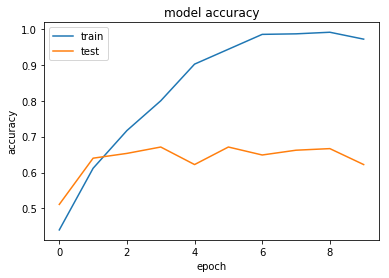

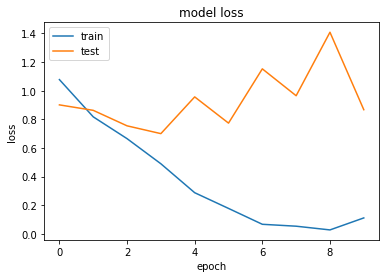

Model saved to disk!
History saved to disk!
Test score: 0.9536557499567667
Test accuracy: 0.613333332935969


In [0]:
if __name__ == '__main__':
    seed = 1337
    np.random.seed(seed)

    epochs = 10
    batch_size = 25
    input_shape = (224,224,3)

    data = np.load('drive/ML-Kaggle/Data/images_labels_224.npz')
    x = data['x']
    y = data['y']
    n_classes = len(np.unique(y))

    X_train, X_val, X_test, y_train, y_val, y_test = train_validation_split(x, y)
    y_train, y_val, y_test = one_hot(y_train, y_val, y_test, n_classes)
    final_model = build_fit_save_cnn(input_shape, n_classes, epochs, batch_size, X_train, X_val, y_train, y_val)
    test_pred, score = test_predict_score(final_model, X_test, y_test)

# Predict

In [0]:
import numpy as np
from sys import argv
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
import pickle, cv2
from keras import optimizers
from keras.models import load_model
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
def load_model():
    json_file = open('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle-weights.h5')

    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loaded_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return loaded_model


In [0]:
def make_prediction(img_path):
    model = load_model()

    with open('drive/ML-Kaggle/Data/class_dict.pkl', 'rb') as f:
        class_dict = pickle.load(f)

    image = cv2.imread(img_path, 1)
    image = prepare_image(image)
    images = []
    images.append(image)
    images = np.array(images)
    image_size = 224
    n_channels = 3
    X_batch = images.reshape(1, image_size, image_size, n_channels)

    preds = model.predict(X_batch)

    top_3 = np.argpartition(preds[0], -3)[-3:]
    top_3 = reversed(top_3[np.argsort(preds[0][top_3])])
    print('Top 3 Predictions:')
    print('------------------')
    for i in top_3:
        print('{0}: {1:.2f}%'.format(class_dict[i], 100 * preds[0][i]))


In [0]:
def prepare_image(image, target_width=224, target_height=224, max_zoom=0.2):
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height

    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)

    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height

    image = image[y0:y1, x0:x1]
    image = cv2.resize(image, (target_width, target_height))

    return image.astype(np.float32) / 255

In [0]:
if __name__ == '__main__':
    img_path = "drive/ML-Kaggle/UnseenData/Surrealism/39150.jpg"
    make_prediction(img_path)

Top 3 Predictions:
------------------
Surrealism: 86.52%
Expressionism: 13.11%
Impressionism: 0.37%
